In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import hilbert

import pandas as pd

import py.continuum1d as continuum1d
c1d = continuum1d.continuum1d()

from py.params import setParams
from py.analysis import computeFPs, checkFixPtsStability, violationType, a_jkValues, lmbd
from py.turings import checkStability
from py.funcs import getSwitchIndex

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

1d Model initialised.


In [2]:
def rotation_in_latency(array):
    """This function determines, based on the phase latency, into which direction the traveling waves rotate.
    INPUT:
    :array: numpy array, 1-dimensional, consists of the phase latency 
            ('how many time steps it takes node to cross the threshold 2\pi') per node (i.e. dim(array)=params.n)
            
    OUTPUT:
    :rotation: -1 (clockwise), or +1 (counterclockwise)
    """
    
    max_arg = np.argmax(array)
    argmax_before = max_arg-1
    argmax_after = max_arg+1
    if argmax_after == len(array):
        argmax_after=0
    diff_to_left = np.abs(array[max_arg]-array[int(argmax_before)])
    diff_to_right = np.abs(array[max_arg]-array[int(argmax_after)])
    
    if diff_to_left>diff_to_right:
        rotation = +1 #"counterclockwise"
    else:
        rotation = -1 #"clockwise"

    return rotation

def count_nodes_for_descent(array, rotation):
    """This function determines the amount of nodes that are necessary for one full phase transition from max to min
    i.e. how many nodes are necessary for one full phase
    INPUT: 
    :array: numpy array, 1-dimensional, consists of the phase latency 
            ('how many time steps it takes node to cross the threshold 2\pi') per node (i.e. dim(array)=params.n)
    :rotation: identifies in which direction we have to descent to count until next max
    
    OUTPUT:
    :count: amount of nodes that are necessary until the next full phase transition starts
    """
    
    max_arg = np.argmax(array)
    
    count = 0
    node = max_arg
    if rotation<0:
        while array[node-1] < array[node]:
            count += 1
            node -= 1
            node = int(node)
            if node >= len(array)-1:
                node = 0
    else:
        while array[node+1] < array[node]:
            count += 1
            node += 1
            node = int(node)
            if node >= len(array)-1:
                node = 0
            
    
    return count

In [3]:
def hilbert_trafo_nd(signal, axis=0):
    """simply the call of the off-shelf implementation to not have to calculate it for every feature individually.
    INPUT:
    :signal: (n,m)-dimensional array of real-valued signal. 
    We have activity=(rows,columns)=(time,nodes) -> default-axis=0.
    
    :output: (n,m)-dimensional array analytical representation of signal
    """
    from scipy.signal import hilbert
    
    #compute Hilbert Transform for analytical signal representation
    #ue.shape = (time-steps+1, number of nodes)
    #i.e. rows=time, columns=node -> want hilbert trafo w.r.t. time => axis=0
    ana_signal = hilbert(signal, axis=axis)
    
    return(ana_signal)

def hilbert_trafo_1d(signal):
    """simply the call of the off-shelf implementation to not have to calculate it for every feature individually"""
    from scipy.signal import hilbert
    
    ana_signal = hilbert(signal)
    
    return(ana_signal)

def inst_phase(signal):
    """Compute the instantaneous phase per time step per node."""
    
    #without unwrapping?
    inst_phase = np.unwrap(np.angle(signal))
    
    #inst_phase = np.unwrap(np.angle(signal))
    
    return inst_phase

def inst_frequ(signal):
    """ This function is supposed to determine the instantaneous frequency of a real-valued signal. 
    We use the method from Muller et al (2014), DOI: 10.1038/ncomms4675.
    
    INPUT:
    :signal: analytical representation (a+ib) of real-valued times series, 1-dimensional, array
    
    :output: instantaneous frequency without phase unwrapping, array"""
    
    
    #compute Hilbert Transform for analytical signal representation
    #ue.shape = (time-steps+1, number of nodes)
    #i.e. rows=time, columns=node -> want hilbert trafo w.r.t. time => axis=0
   # ana_signal = hilbert(signal)#, axis=0)
    
    complex_conj = np.conj(signal)
    #roll complex conjugate s.t. in product we compute 
    #(X_n\cdotX^*_{n+1} i.e. we multiply the analytical representation of signal 
    #at space step n with the complex conjugate of the next space step n+1)
    complex_conj = np.roll(complex_conj, -1)
    
    #use elementwise multiplication
    inst_frequ_temp = np.angle(np.multiply(signal, complex_conj))
    
    #omit last one, since it would be the product of X_n\cdotX^*_0
    inst_frequ = inst_frequ_temp[:-1]
    
    return inst_frequ
    

# explicit function to normalize array (for visualisation reasons - very helpful!)
def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr

In [5]:
ee = -0.3
ii = -0.75

params={'I_e': ee, 'I_i': ii, 'b': 0.25, 'end_t': 15*1000, 'mu_a': 0.4, 'beta_a': 10, 'n': 526}

ps = setParams(params)
fps = computeFPs(ps)
stab = checkFixPtsStability(fps, ps)

k=np.linspace(-3,3,51)

a_ee, a_ei, a_ie, a_ii = a_jkValues(fps[-1], ps)

print('fixed points %s ' %str(fps))
print('with (mass) stability %s'  %str(stab))

fp = fps[0]
checkStability(k, fp, ps)

fixed points [[0.22389562 0.24170095]] 
with (mass) stability [0]


(1, 1, 0)

In [6]:
ue_fast, ui = c1d.run(ps, itype='inte_adaptation', fp=fp)

Text(0, 0.5, 'space')

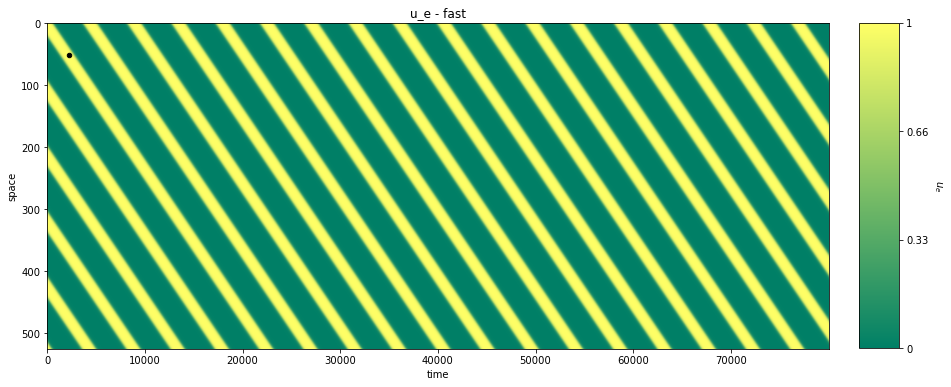

In [37]:
cmap = 'summer'
fig, ax = plt.subplots(1, 1, figsize=(14,6))

pos = ax.imshow(ue_fast.T[:,-80000:], vmin=0, vmax=1, aspect='auto', cmap=cmap)
colors = ['black', 'dimgray', 'silver']

ax.scatter(fast_max, -fast_rotation*fast_count, s=20, color='black')

ax.set_title(label='u_e - fast')

cbar_ticks=np.linspace(0,1,4)
cb_ax = fig.add_axes([.93,.126,.04,.754])
cbar = ax.figure.colorbar(pos, ax=ax, ticks=cbar_ticks, cax=cb_ax)
cbar.ax.set_ylabel(r'$u_e$', rotation=-90, va="bottom")
cbar.ax.set_yticklabels([0, 0.33, 0.66, 1])

ax.set_xlabel('time')
ax.set_ylabel('space')

In [8]:
duration = 10
dur_steps = int(duration * (1/ps.dt) * 1000)
signal = hilbert_trafo_nd(ue_fast[-dur_steps:,:], axis=0)
phases_fast = inst_phase(signal)

In [9]:
phases_fast_cut = phases_fast[-80000:]
len(phases_fast_cut.T)

526

In [10]:
fast_phase_latencies = np.zeros(len(phases_fast_cut.T))

for idx, node in enumerate(phases_fast_cut.T):
    complex_vector = np.exp(1j * node)
    
    # Extract real and imaginary components of the complex vectors
    real_part = np.real(complex_vector)
    imaginary_part = np.imag(complex_vector)
    
    how_many_time_steps = getSwitchIndex(imaginary_part)
    #print(how_many_time_steps[0])
    fast_phase_latencies[idx] = how_many_time_steps[0]

In [11]:
# assign array and range
array_1d = fast_phase_latencies
range_to_normalize = (0, 1)
fast_phase_latencies_norm = normalize(array_1d, range_to_normalize[0], range_to_normalize[1])

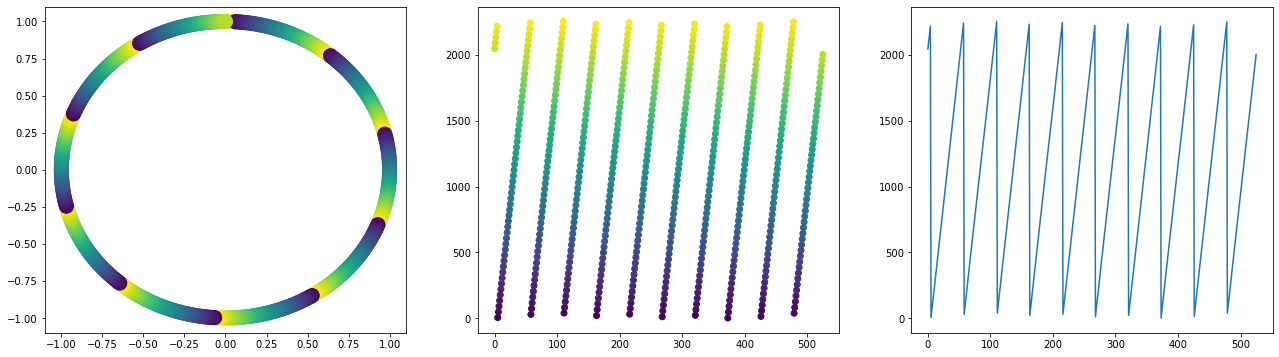

In [12]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(22,6))

ax0.scatter(np.sin(np.linspace(0,2*np.pi, ps.n)),np.cos(np.linspace(0,2*np.pi, ps.n)), c=fast_phase_latencies_norm,
            s=200)

ax1.scatter(np.linspace(0,ps.n-1, ps.n), fast_phase_latencies, c=fast_phase_latencies_norm)

ax2.plot(fast_phase_latencies)

In [13]:
fast_rotation = rotation_in_latency(fast_phase_latencies)
fast_count = count_nodes_for_descent(fast_phase_latencies, fast_rotation)
fast_count, fast_rotation

(52, -1)

In [14]:
ee = 0.85
ii = 0.27

params={'I_e': ee, 'I_i': ii, 'b': 0.25, 'end_t': 25*1000, 'mu_a': 0.4, 'beta_a': 10, 'n': 526, 'tau_a': 6000}

ps = setParams(params)
fps = computeFPs(ps)
stab = checkFixPtsStability(fps, ps)

k=np.linspace(-3,3,51)

a_ee, a_ei, a_ie, a_ii = a_jkValues(fps[-1], ps)

print('fixed points %s ' %str(fps))
print('with (mass) stability %s'  %str(stab))

fp = fps[0]
checkStability(k, fp, ps)

fixed points [[0.11764133 0.62131853]
 [0.6610546  0.99957344]
 [0.99743213 0.99999834]] 
with (mass) stability [1, 0, 1]


(1, 1, 0)

In [15]:
ue_slow, ui = c1d.run(ps, itype='inte_adaptation', fp=fp)

Text(0, 0.5, 'space')

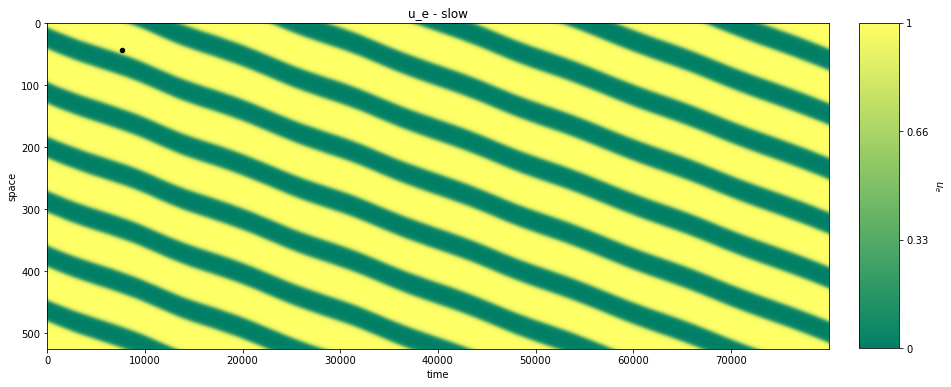

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(14,6))

pos = ax.imshow(ue_slow.T[:,-80000:], vmin=0, vmax=1, aspect='auto', cmap=cmap)
colors = ['black', 'dimgray', 'silver']

ax.scatter(slow_max, -slow_rotation*slow_count, s=20, color='black')

ax.set_title(label='u_e - slow')

cbar_ticks=np.linspace(0,1,4)
cb_ax = fig.add_axes([.93,.126,.04,.754])
cbar = ax.figure.colorbar(pos, ax=ax, ticks=cbar_ticks, cax=cb_ax)
cbar.ax.set_ylabel(r'$u_e$', rotation=-90, va="bottom")
cbar.ax.set_yticklabels([0, 0.33, 0.66, 1])

ax.set_xlabel('time')
ax.set_ylabel('space')

In [16]:
duration = 10
dur_steps = int(duration * (1/ps.dt) * 1000)
signal = hilbert_trafo_nd(ue_slow[-dur_steps:,:], axis=0)
slow_phases = inst_phase(signal)

In [17]:
slow_phases_cut = slow_phases[-80000:]
len(slow_phases_cut.T)

526

In [18]:
slow_phase_latencies = np.zeros(len(slow_phases_cut.T))

for idx, node in enumerate(slow_phases_cut.T):
    complex_vector = np.exp(1j * node)
    
    # Extract real and imaginary components of the complex vectors
    real_part = np.real(complex_vector)
    imaginary_part = np.imag(complex_vector)
    
    how_many_time_steps = getSwitchIndex(imaginary_part)
    #print(how_many_time_steps[0])
    slow_phase_latencies[idx] = how_many_time_steps[0]

In [19]:
# assign array and range
array_1d = slow_phase_latencies
range_to_normalize = (0, 1)
slow_phase_latencies_norm = normalize(array_1d, range_to_normalize[0], range_to_normalize[1])

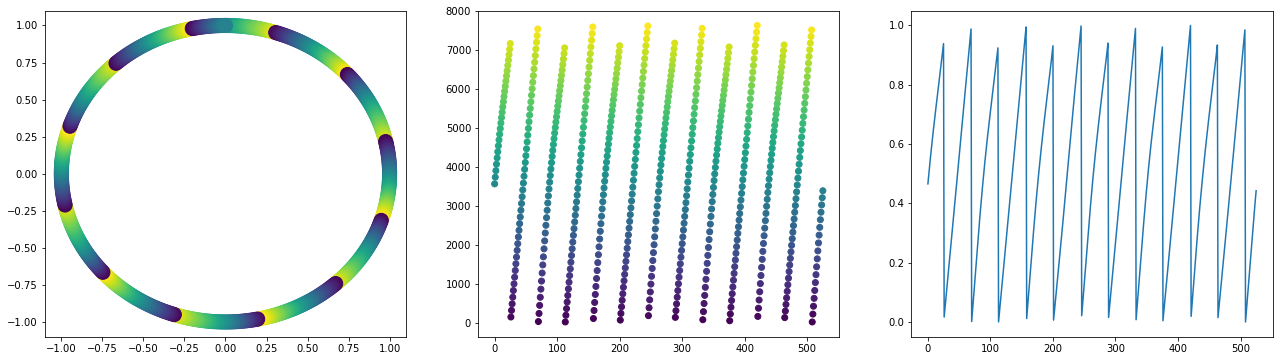

In [20]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(22,6))

ax0.scatter(np.sin(np.linspace(0,2*np.pi, ps.n)),np.cos(np.linspace(0,2*np.pi, ps.n)), c=slow_phase_latencies_norm,
            s=200)

ax1.scatter(np.linspace(0,ps.n-1, ps.n), slow_phase_latencies, c=slow_phase_latencies_norm)

ax2.plot(slow_phase_latencies_norm)

In [21]:
slow_rotation = rotation_in_latency(slow_phase_latencies)
slow_count = count_nodes_for_descent(slow_phase_latencies, slow_rotation)
slow_count, slow_rotation

(44, -1)

In [22]:
ee = 0.85
ii = 0.27

params={'I_e': ee, 'I_i': ii, 'b': 0.25, 'end_t': 25*1000, 'mu_a': 0.4, 'beta_a': 10, 'n': 526, 'tau_a': 200}

ps = setParams(params)
fps = computeFPs(ps)
stab = checkFixPtsStability(fps, ps)

k=np.linspace(-3,3,51)

a_ee, a_ei, a_ie, a_ii = a_jkValues(fps[-1], ps)

print('fixed points %s ' %str(fps))
print('with (mass) stability %s'  %str(stab))

fp = fps[0]
checkStability(k, fp, ps)

fixed points [[0.11764133 0.62131853]
 [0.6610546  0.99957344]
 [0.99743213 0.99999834]] 
with (mass) stability [1, 0, 1]


(1, 1, 0)

In [23]:
ue_lower, ui = c1d.run(ps, itype='inte_adaptation', fp=fp)

Text(0, 0.5, 'space')

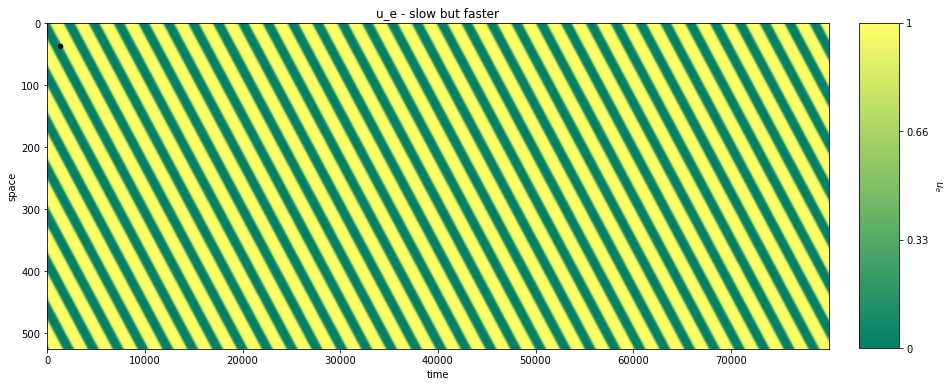

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(14,6))

pos = ax.imshow(ue_lower.T[:,-80000:], vmin=0, vmax=1, aspect='auto', cmap=cmap)
colors = ['black', 'dimgray', 'silver']

ax.scatter(lower_max, -lower_rotation*lower_count, s=20, color='black')

ax.set_title(label='u_e - slow but faster')

cbar_ticks=np.linspace(0,1,4)
cb_ax = fig.add_axes([.93,.126,.04,.754])
cbar = ax.figure.colorbar(pos, ax=ax, ticks=cbar_ticks, cax=cb_ax)
cbar.ax.set_ylabel(r'$u_e$', rotation=-90, va="bottom")
cbar.ax.set_yticklabels([0, 0.33, 0.66, 1])

ax.set_xlabel('time')
ax.set_ylabel('space')

In [24]:
duration = 10
dur_steps = int(duration * (1/ps.dt) * 1000)
signal = hilbert_trafo_nd(ue_lower[-dur_steps:,:], axis=0)
lower_phases = inst_phase(signal)

In [25]:
lower_phases_cut = lower_phases[-80000:]
len(lower_phases_cut.T), len(lower_phases_cut)
lower_phases_cut.T[0]

array([-1.48767671, -1.48697149, -1.48625766, ...,  0.05138144,
        0.0501479 ,  0.12149642])

In [26]:
lower_phase_latencies = np.zeros(len(lower_phases_cut.T))

for idx, node in enumerate(lower_phases_cut.T):
    complex_vector = np.exp(1j * node)
    
    # Extract real and imaginary components of the complex vectors
    real_part = np.real(complex_vector)
    imaginary_part = np.imag(complex_vector)
    
    how_many_time_steps = getSwitchIndex(imaginary_part)
    #print(how_many_time_steps[0])
    lower_phase_latencies[idx] = how_many_time_steps[0]

In [27]:
# assign array and range
array_1d = lower_phase_latencies
range_to_normalize = (0, 1)
lower_phase_latencies_norm = normalize(array_1d, range_to_normalize[0], range_to_normalize[1])

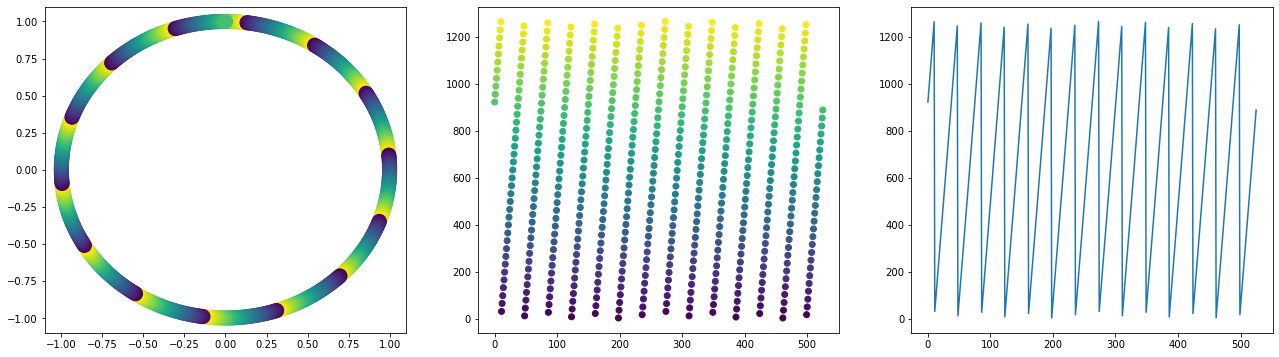

In [28]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(22,6))

ax0.scatter(np.sin(np.linspace(0,2*np.pi, ps.n)),np.cos(np.linspace(0,2*np.pi, ps.n)), c=lower_phase_latencies_norm,
            s=200)

ax1.scatter(np.linspace(0,ps.n-1, ps.n), lower_phase_latencies, c=lower_phase_latencies_norm)

ax2.plot(lower_phase_latencies)

In [29]:
lower_rotation = rotation_in_latency(lower_phase_latencies)
lower_count = count_nodes_for_descent(lower_phase_latencies, lower_rotation)
lower_count, lower_rotation

(37, -1)

In [30]:
fast_max = fast_phase_latencies[np.argmax(fast_phase_latencies)]
slow_max = slow_phase_latencies[np.argmax(slow_phase_latencies)]
lower_max = lower_phase_latencies[np.argmax(lower_phase_latencies)]

(-60.0, 40.0)

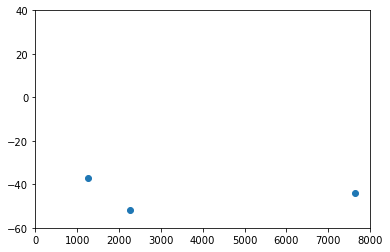

In [31]:
plt.scatter([fast_max, slow_max, lower_max], [fast_rotation*fast_count, 
                                              slow_rotation*slow_count, 
                                              lower_rotation*lower_count])
plt.xlim([0,8000])
plt.ylim([-60,40])

In [32]:
fast_argmax = np.argmax(fast_phase_latencies)
slow_argmax = np.argmax(slow_phase_latencies)
lower_argmax = np.argmax(lower_phase_latencies)

In [33]:
fast_distance = ps.x[0]-ps.x[fast_argmax]
slow_distance = ps.x[0]-ps.x[slow_argmax]
lower_distance = ps.x[0]-ps.x[lower_argmax]

(-15.0, 20.0)

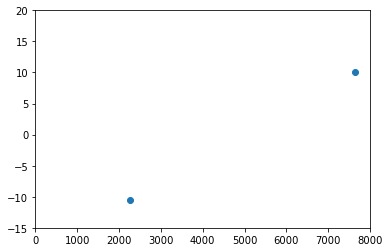

In [34]:
plt.scatter([fast_max, slow_max, lower_max], [fast_rotation*fast_distance, 
                                              slow_rotation*slow_distance, 
                                              lower_rotation*lower_distance])
plt.xlim([0,8000])
plt.ylim([-15,20])

In [6]:
bs = np.linspace(0, 0.5, 21)
taus = np.linspace(0, 6000, 21)
taus[0]=10

In [4]:
def run_latencies(val_array, val_str, ee, ii):

    latencies = np.zeros((len(val_array),2))
    
    for i, value in enumerate(val_array):
        
        params={'I_e': ee, 'I_i': ii, 'b': 0.25, 'end_t': 25*1000, 'mu_a': 0.4, 'beta_a': 10, 'n': 256, 'tau_a': 200}
        
        ps = setParams(params)
        
        ps[val_str] = value
        
        fps = computeFPs(ps)
        stab = checkFixPtsStability(fps, ps)
        
        k=np.linspace(-3,3,51)
        
        a_ee, a_ei, a_ie, a_ii = a_jkValues(fps[-1], ps)
        
        print('fixed points %s ' %str(fps))
        print('with (mass) stability %s'  %str(stab))
        
        fp = fps[0]
        
        ue, ui = c1d.run(ps, itype='inte_adaptation', fp=fp)
        
        duration = 10
        dur_steps = int(duration * (1/ps.dt) * 1000)
        signal = hilbert_trafo_nd(ue[-dur_steps:,:], axis=0)
        phases = inst_phase(signal)
        
        phases_cut = phases[-80000:]
        len(phases_cut.T), len(phases_cut)
        phases_cut.T[0]
        
        phase_latencies = np.zeros(len(phases_cut.T))
    
        for idx, node in enumerate(phases_cut.T):
            complex_vector = np.exp(1j * node)
            
            # Extract real and imaginary components of the complex vectors
            real_part = np.real(complex_vector)
            imaginary_part = np.imag(complex_vector)
            
            how_many_time_steps = getSwitchIndex(imaginary_part)
            #print(how_many_time_steps[0])
            phase_latencies[idx] = how_many_time_steps[0]
            
        rotation = rotation_in_latency(phase_latencies)
        amount_of_nodes = count_nodes_for_descent(phase_latencies, rotation)
        amount_time_steps = phase_latencies[np.argmax(phase_latencies)]
        
        latencies[i] = [amount_time_steps, amount_of_nodes]
        
    return latencies

In [27]:
b_lats = run_latencies(bs, 'b', 0.4, -0.14)

fixed points [[0.17167971 0.48620344]
 [0.75848612 0.99933696]
 [0.99245641 0.99998599]] 
with (mass) stability [1, 0, 1]
fixed points [[0.17097336 0.48483283]
 [0.77030993 0.99945412]
 [0.99130629 0.99998572]] 
with (mass) stability [1, 0, 1]
fixed points [[0.17027682 0.48348136]
 [0.78241484 0.99955271]
 [0.9899499  0.9999854 ]] 
with (mass) stability [1, 0, 1]
fixed points [[0.16958979 0.48214846]
 [0.79484785 0.9996355 ]
 [0.98833737 0.999985  ]] 
with (mass) stability [1, 0, 1]
fixed points [[0.16891201 0.48083361]
 [0.98640043 0.99998452]] 
with (mass) stability [1, 1]
fixed points [[0.16824319 0.47953628]
 [0.82099052 0.99976305]
 [0.98404169 0.9999839 ]] 
with (mass) stability [1, 0, 1]
fixed points [[0.16758309 0.47825599]
 [0.98111439 0.9999831 ]] 
with (mass) stability [1, 1]
fixed points [[0.16693146 0.47699226]
 [0.97737944 0.99998203]] 
with (mass) stability [1, 1]
fixed points [[0.16628808 0.47574465]
 [0.97239803 0.99998049]] 
with (mass) stability [1, 1]
fixed points [

In [26]:
tau_lats = run_latencies(taus, 'tau_a', 0.4, -0.14)

fixed points [[0.16502514 0.47329606]
 [0.95199638 0.99997269]] 
with (mass) stability [1, 1]
fixed points [[0.16502514 0.47329606]
 [0.95199638 0.99997269]] 
with (mass) stability [1, 1]
fixed points [[0.16502514 0.47329606]
 [0.95199638 0.99997269]] 
with (mass) stability [1, 1]
fixed points [[0.16502514 0.47329606]
 [0.95199638 0.99997269]] 
with (mass) stability [1, 1]
fixed points [[0.16502514 0.47329606]
 [0.95199638 0.99997269]] 
with (mass) stability [1, 1]
fixed points [[0.16502514 0.47329606]
 [0.95199638 0.99997269]] 
with (mass) stability [1, 1]
fixed points [[0.16502514 0.47329606]
 [0.95199638 0.99997269]] 
with (mass) stability [1, 1]
fixed points [[0.16502514 0.47329606]
 [0.95199638 0.99997269]] 
with (mass) stability [1, 1]
fixed points [[0.16502514 0.47329606]
 [0.95199638 0.99997269]] 
with (mass) stability [1, 1]
fixed points [[0.16502514 0.47329606]
 [0.95199638 0.99997269]] 
with (mass) stability [1, 1]
fixed points [[0.16502514 0.47329606]
 [0.95199638 0.9999726

b:  [11445.    18.]
b:  [3358.   21.]
b:  [2455.   21.]
b:  [1993.   21.]
b:  [1707.   21.]
b:  [1526.   21.]
b:  [1397.   21.]
b:  [1275.   25.]
b:  [1199.   31.]
b:  [1111.   18.]
b:  [1052.   18.]
b:  [1002.   18.]
b:  [978.  18.]
b:  [925.  18.]
b:  [897.  18.]
b:  [869.  18.]
tau:  [889.  18.]
tau:  [1988.   21.]
tau:  [2619.   21.]
tau:  [3153.   21.]
tau:  [3569.   21.]
tau:  [3979.   21.]
tau:  [4497.   21.]
tau:  [4692.   21.]
tau:  [4989.   21.]
tau:  [5074.   21.]
tau:  [5580.   21.]
tau:  [5503.   21.]
tau:  [6005.   21.]
tau:  [6236.   21.]
tau:  [6370.   18.]
tau:  [7006.   17.]


(-1.0, 32.0)

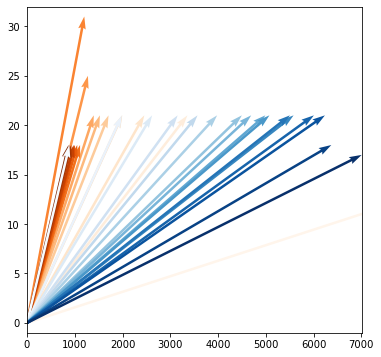

In [124]:
from matplotlib import cm

colors_b = cm.get_cmap('Oranges', len(bs))
colors_tau = cm.get_cmap('Blues', len(taus))

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6))
for ind, pair in enumerate(b_lats):
    print('b: ', pair)
    ax0.quiver(0, 0, pair[0], pair[1], angles='xy', scale_units='xy', scale=1, color=colors_b(ind))
    
for ind, pair in enumerate(tau_lats):
    print('tau: ', pair)
    ax1.quiver(0, 0, pair[0], pair[1], angles='xy', scale_units='xy', scale=1, color=colors_tau(ind))
    

# Set axis limits based on the vectors
ax.set_xlim([-1, np.max(tau_lats[:,0])+1])
ax.set_ylim([-1, np.max(b_lats[:,1])+1])

In [28]:
b_df = pd.DataFrame(b_lats, index=bs, columns=['#time_steps', '#nodes'])
b_df.to_csv('phase_lats/ee04_ii_minus014_b.csv')

In [29]:
tau_df = pd.DataFrame(tau_lats, index=taus, columns=['#time_steps', '#nodes'])
tau_df.to_csv('phase_lats/ee04_ii_minus014_tau.csv')